In [1]:
import numpy as np
from __future__ import division

filename = 'glove.6B.100d.txt'

def loadEmbeddings(filename):
    vocab = []
    embd = []
    file = open(filename,'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab.append(row[0])
        embd.append(row[1:])
    print('Loaded!')
    file.close()
    return vocab,embd
vocab,embd = loadEmbeddings(filename)


word_vec_dim = len(embd[0])

vocab.append('<UNK>')
embd.append(np.asarray(embd[vocab.index('unk')],np.float32)+0.01)

vocab.append('<EOS>')
embd.append(np.asarray(embd[vocab.index('eos')],np.float32)+0.01)

vocab.append('<PAD>')
embd.append(np.zeros((word_vec_dim),np.float32))

embedding = np.asarray(embd)
embedding = embedding.astype(np.float32)

def word2vec(word):  # converts a given word into its vector representation
    if word in vocab:
        return embedding[vocab.index(word)]
    else:
        return embedding[vocab.index('<UNK>')]

def most_similar_eucli(x):
    xminusy = np.subtract(embedding,x)
    sq_xminusy = np.square(xminusy)
    sum_sq_xminusy = np.sum(sq_xminusy,1)
    eucli_dists = np.sqrt(sum_sq_xminusy)
    return np.argsort(eucli_dists)

def vec2word(vec):   # converts a given vector representation into the represented word 
    most_similars = most_similar_eucli(np.asarray(vec,np.float32))
    return vocab[most_similars[0]]

import pickle

with open ('embeddingPICKLE', 'rb') as fp:
    processed_data = pickle.load(fp)

fact_stories = processed_data[0]
questions = processed_data[1]
answers = np.reshape(processed_data[2],(len(processed_data[2])))
test_fact_stories = processed_data[3]
test_questions = processed_data[4]
test_answers = np.reshape(processed_data[5],(len(processed_data[5])))

Loaded!


In [2]:
import random

print "EXAMPLE DATA:\n"

sample = random.randint(0,len(fact_stories))

print "FACTS:\n"
for i in xrange(len(fact_stories[sample])):
    print str(i+1)+") ",
    print map(vec2word,fact_stories[sample][i])
    
print "\nQUESTION:"
print map(vec2word,questions[sample])
print "\nANSWER:"
print vocab[answers[sample]]

EXAMPLE DATA:

FACTS:

1)  ['lily', 'is', 'a', 'frog']
2)  ['brian', 'is', 'a', 'rhino']
3)  ['bernhard', 'is', 'a', 'frog']
4)  ['bernhard', 'is', 'green', '<PAD>']
5)  ['greg', 'is', 'a', 'lion']
6)  ['julius', 'is', 'a', 'lion']
7)  ['brian', 'is', 'green', '<PAD>']
8)  ['julius', 'is', 'gray', '<PAD>']
9)  ['lily', 'is', 'green', '<PAD>']

QUESTION:
['what', 'color', 'is', 'greg']

ANSWER:
gray


In [3]:
from __future__ import division

train_fact_stories = []
train_questions = []
train_answers = []
val_fact_stories = []
val_questions = []
val_answers = []

p=90 #(90% data used for training. Rest for validation)
    
train_len = int((p/100)*len(fact_stories))
val_len = int(((100-p)/100)*len(fact_stories))

train_fact_stories = fact_stories[0:train_len] 
val_fact_stories = fact_stories[train_len:(train_len+val_len)]

train_questions = questions[0:train_len] 
val_questions = questions[train_len:(train_len+val_len)] 

train_answers = answers[0:train_len] 
val_answers = answers[train_len:(train_len+val_len)] 


In [4]:
# from __future__ import division

def sentence_reader(fact_stories): #positional_encoder
    
    PAD_val = np.zeros((word_vec_dim),np.float32)
    
    pe_fact_stories = np.zeros((fact_stories.shape[0],fact_stories.shape[1],word_vec_dim),np.float32)
    
    for fact_story_index in xrange(0,len(fact_stories)):
        for fact_index in xrange(0,len(fact_stories[fact_story_index])):
            
            M = 0
            
            # Code to ignore pads. 
            for word_position in xrange(len(fact_stories[fact_story_index,fact_index])):
                if np.all(np.equal(PAD_val,fact_stories[fact_story_index,fact_index,word_position])):
                    break
                else:
                    M+=1
                
            l = np.zeros((word_vec_dim),np.float32) 
            
            # ljd = (1 − j/M) − (d/D)(1 − 2j/M),
            
            for word_position in xrange(0,M):
                
                for dimension in xrange(0,word_vec_dim):
                    
                    j = word_position + 1 # making position start from 1 instead of 0
                    d = dimension + 1 # making dimensions start from 1 isntead of 0 (1-100 instead of 0-99)
                    
                    l[dimension] = (1-(j/M)) - (d/word_vec_dim)*(1-2*(j/M))
 
                
                pe_fact_stories[fact_story_index,fact_index] += np.multiply(l,fact_stories[fact_story_index,fact_index,word_position])


    return pe_fact_stories

train_fact_stories = sentence_reader(train_fact_stories)
val_fact_stories = sentence_reader(val_fact_stories)
test_fact_stories = sentence_reader(test_fact_stories)
                
        

In [5]:
def create_batches(fact_stories,questions,answers,batch_size):
    
    shuffle = np.arange(len(questions))
    np.random.shuffle(shuffle)
    
    batches_fact_stories = []
    batches_questions = []
    batches_answers = []
    
    i=0
    
    while i+batch_size<=len(questions):
        batch_fact_stories = []
        batch_questions = []
        batch_answers = []
        
        for j in xrange(i,i+batch_size):
            batch_fact_stories.append(fact_stories[shuffle[j]])
            batch_questions.append(questions[shuffle[j]])
            batch_answers.append(answers[shuffle[j]])

        batches_fact_stories.append(batch_fact_stories)
        batches_questions.append(batch_questions)
        batches_answers.append(batch_answers)
        
        i+=batch_size
        
    batches_fact_stories = np.asarray(batches_fact_stories,np.float32)
    batches_questions = np.asarray(batches_questions,np.float32)
    batches_answers = np.asarray(batches_answers,np.int32)
    
    return batches_fact_stories,batches_questions,batches_answers
    


In [6]:
import tensorflow as tf

# Tensorflow placeholders

tf_facts = tf.placeholder(tf.float32,[None,None,word_vec_dim])
tf_questions = tf.placeholder(tf.float32, [None,None,word_vec_dim])
tf_answers = tf.placeholder(tf.int32,[None])
training= tf.placeholder(tf.bool)

#hyperparameters
epochs = 256
learning_rate = 0.001
hidden_size = 100
dropout_rate = 0.2
beta = 0.0001 #l2 regularization scale
regularizer = tf.contrib.layers.l2_regularizer(scale=beta)


In [7]:
wpd = tf.transpose(tf.convert_to_tensor(embedding))

In [8]:

def layer_norm(inputs,scope,scale=True,layer_norm=True,epsilon = 1e-5):
    
    if layer_norm == True:
        
        with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
            
            if scale == False:
                scale = tf.ones([inputs.get_shape()[1]],tf.float32)
            else:
                scale = tf.get_variable("scale", shape=[inputs.get_shape()[1]],
                        initializer=tf.ones_initializer())
        
        
        ## ignored shift - bias will be externally added which can produce shift

        mean, var = tf.nn.moments(inputs, [1], keep_dims=True)
        
        LN = tf.multiply((scale / tf.sqrt(var + epsilon)),(inputs - mean))
        
        return LN
    else:
        return inputs

In [9]:
def bi_GRU(inp,hidden,seq_len,scope):
    
    #inp shape = batch_size x seq_len x vector_dimension
    inp = tf.transpose(inp,[1,0,2])
    
    #now inp shape = seq_len x batch_size x vector_dimension
    
    hidden_forward = tf.TensorArray(size=seq_len,dtype=tf.float32)
    hidden_backward = tf.TensorArray(size=seq_len,dtype=tf.float32)
    
    hiddenf = hidden
    hiddenb = hidden

    hidden_size = hidden.get_shape()[-1]
    word_vec_dim = inp.get_shape()[-1]
    
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        
        w = tf.get_variable("w", shape=[6,word_vec_dim, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer= regularizer)
        u = tf.get_variable("u", shape=[6,hidden_size, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
        b = tf.get_variable("b", shape=[6,hidden_size],initializer=tf.zeros_initializer())
        
    i = 0
    j = seq_len - 1
    
    def cond(i,j,hiddenf,hiddenb,hidden_forward,hidden_backward):
        return i < seq_len
    
    def body(i,j,hiddenf,hiddenb,hidden_forward,hidden_backward):
        
        xf = inp[i]
        xb = inp[j]

        # FORWARD GRU EQUATIONS:
        z = tf.sigmoid(layer_norm( tf.matmul(xf,w[0]) + tf.matmul(hidden,u[0]) , scope+"f_z")+ b[0])
        r = tf.sigmoid(layer_norm( tf.matmul(xf,w[1]) + tf.matmul(hidden,u[1]) , scope+"f_r")+ b[1])
        h_ = tf.tanh(layer_norm( tf.matmul(xf,w[2]) + tf.multiply(r,tf.matmul(hiddenf,u[2])),scope+"f_h") + b[2])
        hiddenf = tf.multiply(z,h_) + tf.multiply((1-z),hiddenf)

        hidden_forward = hidden_forward.write(i,hiddenf)
        
        # BACKWARD GRU EQUATIONS:
        z = tf.sigmoid(layer_norm( tf.matmul(xb,w[3]) + tf.matmul(hidden,u[3]) , scope+"b_z")+ b[0])
        r = tf.sigmoid(layer_norm( tf.matmul(xb,w[4]) + tf.matmul(hidden,u[4]) , scope+"b_r")+ b[1])
        h_ = tf.tanh(layer_norm( tf.matmul(xb,w[5]) + tf.multiply(r,tf.matmul(hiddenb,u[5])),scope+"b_h") + b[2])
        hiddenb = tf.multiply(z,h_) + tf.multiply((1-z),hiddenb)
        
        hidden_backward = hidden_backward.write(j,hiddenb)
        
        
        return i+1,j-1,hiddenf,hiddenb,hidden_forward,hidden_backward
    
    _,_,_,_,hidden_forward,hidden_backward = tf.while_loop(cond,body,[i,j,
                                                                        hiddenf,
                                                                        hiddenb,
                                                                        hidden_forward,
                                                                        hidden_backward])
    
    forward = hidden_forward.stack()
    backward = hidden_backward.stack()
    
    hidden_list = (forward + backward)
    
    #forward\backward\hidden_list shape = seq_len x  batch_size x hidden_size
    
    hidden_list = tf.transpose(hidden_list,[1,0,2])
    
    return hidden_list

In [10]:
def GRU(inp,hidden,
        seq_len,scope):
    
    #inp shape = batch_size x seq_len x vector_dimension
    inp = tf.transpose(inp,[1,0,2])

    hidden_lists = tf.TensorArray(size=seq_len,dtype=tf.float32)
    
    hidden_size = hidden.get_shape()[-1]
    word_vec_dim = inp.get_shape()[-1]
    
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        
        w = tf.get_variable("w", shape=[3,word_vec_dim, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer= regularizer)
        u = tf.get_variable("u", shape=[3,hidden_size, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
        b = tf.get_variable("b", shape=[3,hidden_size],initializer=tf.zeros_initializer())
    
    i=0
    
    def cond(i,hidden,hidden_lists):
        return i < seq_len
    
    def body(i,hidden,hidden_lists):
        
        x = inp[i]
 
        # GRU EQUATIONS:
        z = tf.sigmoid(layer_norm( tf.matmul(x,w[0]) + tf.matmul(hidden,u[0]) , scope+"_z")+ b[0])
        r = tf.sigmoid(layer_norm( tf.matmul(x,w[1]) + tf.matmul(hidden,u[1]) , scope+"_r")+ b[1])
        h_ = tf.tanh(layer_norm( tf.matmul(x,w[2]) + tf.multiply(r,tf.matmul(hidden,u[2])),scope+"_h") + b[2])
        hidden = tf.multiply(z,h_) + tf.multiply((1-z),hidden)

        hidden_lists = hidden_lists.write(i,hidden)
        
        return i+1,hidden,hidden_lists
    
    _,_,hidden_lists = tf.while_loop(cond,body,[i,hidden,hidden_lists])
    
    hidden_lists = hidden_lists.stack()
    hidden_lists = tf.transpose(hidden_lists,[1,0,2])
    
    return hidden_lists
        

In [11]:
def gated_attention_based_GRU(qr,facts,scope):
    
    qr_vec_size = qr.get_shape()[-1]
    p_vec_size = facts.get_shape()[-1]
    hidden_size = qr_vec_size
        
    seq_len = tf.shape(facts)[1]
    question_len = tf.shape(qr)[1]
    batch_size = tf.shape(facts)[0]
    
    hidden_lists = tf.TensorArray(size=seq_len,dtype=tf.float32)
    vp = tf.zeros([batch_size,qr_vec_size+p_vec_size],tf.float32)
    
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        
        wqu = tf.get_variable("wqu", shape=[qr_vec_size, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer= regularizer)
        wpu = tf.get_variable("wpu", shape=[p_vec_size, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
        wvp = tf.get_variable("wvp", shape=[qr_vec_size+p_vec_size, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
        v = tf.get_variable("v", shape=[hidden_size, 1],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
        wg = tf.get_variable("wg", shape=[qr_vec_size+p_vec_size, 1],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
        
    # facts shape = batch_size x facts_num x p_vec_size

    facts = tf.transpose(facts,[1,0,2])
    
    # now facts shape = facts_num x batch_size x p_vec_size
    
    # qr shape = batch_size x question_len x qr_vec_size
    qr = tf.transpose(qr,[1,0,2])
    # now qr shape =  question_len x batch_size x qr_vec_size
    
    i = 0
    
    def cond(i,vp,hidden_lists):
        return i < seq_len
    
    def body(i,vp,hidden_lists):
        
        qr_part = tf.reshape(qr,[question_len*batch_size,qr_vec_size])
        qr_part = tf.matmul(qr_part,wqu)
        qr_part = tf.reshape(qr_part,[question_len,batch_size,hidden_size])

        facts_part = tf.matmul(facts[i],wpu)
        facts_part = tf.reshape(facts_part,[1,batch_size,hidden_size])
        
        vp_part = tf.matmul(vp,wvp)
        vp_part = tf.reshape(vp_part,[1,batch_size,hidden_size])
        
    
        s = tf.tanh(qr_part + facts_part + vp_part)
        s = tf.reshape(s,[question_len*batch_size,hidden_size])
        
        s = tf.matmul(s,v)
        
        s = tf.reshape(s,[question_len,batch_size])
        s = tf.transpose(s,[1,0])
        
        # now s shape = batch_size x question_len
        
        a = tf.nn.softmax(s)
        
        # a shape = batch_size x question_len
        
        a = tf.transpose(a)
        
        # a shape = question_len x batch_size
        
        a = tf.reshape(a,[question_len,batch_size,1])
        
        c = tf.multiply(a,qr)
        
        c = tf.reduce_sum(c,0)
        
        # c (context vector) shape = batch_size x qr_vec_size
     
        uc = tf.concat([facts[i],c],1)
        g = tf.nn.sigmoid(tf.matmul(uc,wg))
        uc_ = tf.multiply(g,uc)
        
        # uc_ shape =batch_size x (qr_vec_size+p_vec_size)
        
        vp = bi_GRU(tf.reshape(vp,[batch_size,1,qr_vec_size+p_vec_size]),uc_,1,scope)
        
        vp = tf.reshape(vp,[batch_size,qr_vec_size+p_vec_size])
        
        hidden_lists = hidden_lists.write(i,vp)
   
        return i+1,vp,hidden_lists
    
    _,_,hidden_lists = tf.while_loop(cond,body,[i,vp,hidden_lists])
    
    hidden_lists = hidden_lists.stack()
    
    # hidden_lists shape = facts_num x batch_size x (p_vec_dim + qr_vec_dim)
    
    hidden_lists = tf.transpose(hidden_lists,[1,0,2])
    
    # now hidden_lists shape = batch_size x facts_num x (p_vec_dim + qr_vec_dim)
    
    return hidden_lists
    

In [12]:
def self_matching_attention(vp,scope):
    
    hidden_size = vp.get_shape()[-1]
    seq_len = tf.shape(vp)[1]
    batch_size = tf.shape(vp)[0]
    
    hidden_lists = tf.TensorArray(size=seq_len,dtype=tf.float32)
    hp = tf.zeros([batch_size,hidden_size+hidden_size],tf.float32)
    
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        
        wvp_whole = tf.get_variable("wvp1", shape=[hidden_size, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer= regularizer)
        wvp_single = tf.get_variable("wvp2", shape=[hidden_size, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
        v = tf.get_variable("v", shape=[hidden_size, 1],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
        
    # vp shape = batch_size x facts_num x hidden_size

    vp = tf.transpose(vp,[1,0,2])
    
    # now vp shape = facts_num x batch_size x hidden_size
    
    i = 0
    
    def cond(i,hp,hidden_lists):
        return i < seq_len
    
    def body(i,hp,hidden_lists):
        
        vp_whole_part = tf.reshape(vp,[seq_len*batch_size,hidden_size])
        vp_whole_part = tf.matmul(vp_whole_part,wvp_whole)
        vp_whole_part = tf.reshape(vp_whole_part,[seq_len,batch_size,hidden_size])
        
        vp_single_part = tf.matmul(vp[i],wvp_single)
        vp_single_part = tf.reshape(vp_single_part,[1,batch_size,hidden_size])
    
        s = tf.tanh(vp_whole_part + vp_single_part)
        s = tf.reshape(s,[seq_len*batch_size,hidden_size])
        
        s = tf.matmul(s,v)
        
        s = tf.reshape(s,[seq_len,batch_size])
        s = tf.transpose(s,[1,0])
        
        # now s shape = batch_size x facts_num
        
        a = tf.nn.softmax(s)
        
        # a shape = batch_size x facts_num
        
        a = tf.transpose(a)
        
        # a shape = facts_num x batch_size
        
        a = tf.reshape(a,[seq_len,batch_size,1])
        
        c = tf.multiply(a,vp)
        
        c = tf.reduce_sum(c,0)
        
        # c (context vector) shape = batch_size x hidden_size
     
        vpc = tf.concat([vp[i],c],1)
        
        # vpc shape =batch_size x 2*hidden_size
        
        hp = bi_GRU(tf.reshape(hp,[batch_size,1,hidden_size+hidden_size]),vpc,1,scope)
        
        hp = tf.reshape(hp,[batch_size,hidden_size+hidden_size])
        
        hidden_lists = hidden_lists.write(i,hp)
   
        return i+1,hp,hidden_lists
    
    _,_,hidden_lists = tf.while_loop(cond,body,[i,hp,hidden_lists])
    
    hidden_lists = hidden_lists.stack()
    
    # hidden_lists shape = facts_num x batch_size x hidden_size
    
    hidden_lists = tf.transpose(hidden_lists,[1,0,2])
    
    # now hidden_lists shape = batch_size x facts_num x hidden_size
    
    return hidden_lists
    

In [13]:
def R_NET(tf_facts,tf_questions):
    
    tf_batch_size = tf.shape(tf_facts)[0]
    facts_num = tf.shape(tf_facts)[1]
    
    question_len = tf.shape(tf_questions)[1]
    
    hidden = tf.zeros([tf_batch_size,hidden_size],tf.float32)
    
    # word level question encoding
    qr = bi_GRU(tf_questions,hidden,question_len,scope="question_encoding")
    
    #now qr shape = batch_size x question_len x 2*hidden_size
    
    
    # Encoding facts
    tf_facts = bi_GRU(tf_facts,hidden,
                      facts_num,
                      scope="facts_encoding")
    
    # now tf_facts shape = batch_size x facts_num x 2*hidden_size
    
    tf_facts = tf.layers.dropout(tf_facts,dropout_rate,training=training)
    
    # Producing question aware document representation through gated attention based RNN. 
    
    qr_facts = gated_attention_based_GRU(qr,tf_facts,"gated_attention")
    
    qr_facts = tf.layers.dropout(qr_facts,dropout_rate,training=training)
    
    # Producing final passage representation through self-matching attention.
    
    hp_list = self_matching_attention(qr_facts,"self_matching_attention")
    
    hp_list = tf.layers.dropout(hp_list,dropout_rate,training=training)
    
    predicted_word = GRU(hp_list,hidden,facts_num,"answer_layer")
    predicted_word = predicted_word[:,facts_num-1]
    
    predicted_word = tf.layers.dropout(predicted_word,dropout_rate,training=training)
    
    # Convert to pre-softmax probability distribution
    y = tf.matmul(predicted_word,wpd)
    
    return y
    
    

In [14]:
model_output = R_NET(tf_facts,tf_questions)


# l2 regularization
#reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
regularization = 0#tf.contrib.layers.apply_regularization(regularizer, tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, 
                                                                     labels=tf_answers))+regularization

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

model_output = tf.nn.softmax(model_output)

#Evaluate model
correct_pred = tf.equal(tf.cast(tf.argmax(model_output,1),tf.int32),tf_answers)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [15]:
with tf.Session() as sess: # Start Tensorflow Session
    
    saver = tf.train.Saver() 

    sess.run(init) #initialize all variables
    step = 1   
    loss_list=[]
    acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    best_val_acc=0
    best_val_loss=2**30
    prev_val_acc=0
    patience = 20
    impatience = 0
    display_step = 20
    min_epoch = 20
            
    batch_size = 128
    
    while step <= epochs:
        
        total_loss=0
        total_acc=0
        total_val_loss = 0
        total_val_acc = 0

        batches_train_fact_stories,batches_train_questions,batches_train_answers = create_batches(train_fact_stories,train_questions,train_answers,batch_size)
        
        for i in xrange(len(batches_train_questions)):
            
            # Run optimization operation (backpropagation)
            _,loss,acc = sess.run([optimizer,cost,accuracy],
                                       feed_dict={tf_facts: batches_train_fact_stories[i], 
                                                  tf_questions: batches_train_questions[i], 
                                                  tf_answers: batches_train_answers[i],
                                                  training: True})

            total_loss += loss
            total_acc += acc
                
            if i%display_step == 0:
                print "Iter "+str(i)+", Loss= "+\
                      "{:.3f}".format(loss)+", Accuracy= "+\
                      "{:.3f}".format(acc*100)
                        
        avg_loss = total_loss/len(batches_train_questions) 
        avg_acc = total_acc/len(batches_train_questions)  
        
        loss_list.append(avg_loss) 
        acc_list.append(avg_acc) 

        val_batch_size = 100 #(should be able to divide total no. of validation samples without remainder)
        batches_val_fact_stories,batches_val_questions,batches_val_answers = create_batches(val_fact_stories,val_questions,val_answers,val_batch_size)
        
        for i in xrange(len(batches_val_questions)):
            val_loss, val_acc = sess.run([cost, accuracy], 
                                         feed_dict={tf_facts: batches_val_fact_stories[i], 
                                                    tf_questions: batches_val_questions[i], 
                                                    tf_answers: batches_val_answers[i],
                                                    training: False})
            total_val_loss += val_loss
            total_val_acc += val_acc
                      
            
        avg_val_loss = total_val_loss/len(batches_val_questions) 
        avg_val_acc = total_val_acc/len(batches_val_questions) 
             
        val_loss_list.append(avg_val_loss) 
        val_acc_list.append(avg_val_acc) 
    

        print "\nEpoch " + str(step) + ", Validation Loss= " + \
                "{:.3f}".format(avg_val_loss) + ", validation Accuracy= " + \
                "{:.3f}%".format(avg_val_acc*100)+""
        print "Epoch " + str(step) + ", Average Training Loss= " + \
              "{:.3f}".format(avg_loss) + ", Average Training Accuracy= " + \
              "{:.3f}%".format(avg_acc*100)+""
        
        impatience += 1
        
        if avg_val_acc >= best_val_acc:
            best_val_acc = avg_val_acc
            saver.save(sess, 'DMN_Model_Backup/model.ckpt') 
            print "Checkpoint created!"


    
        if avg_val_loss <= best_val_loss: 
            impatience=0
            best_val_loss = avg_val_loss


        
        if impatience > patience and step>min_epoch:
            print "\nEarly Stopping since best validation loss not decreasing for "+str(patience)+" epochs."
            break
            
        print ""
        step += 1
        
    
        
    print "\nOptimization Finished!\n"
    
    print "Best Validation Accuracy: %.3f%%"%((best_val_acc*100))
    

Iter 0, Loss= 16.367, Accuracy= 0.000
Iter 20, Loss= 1.889, Accuracy= 21.875
Iter 40, Loss= 1.664, Accuracy= 28.125
Iter 60, Loss= 1.669, Accuracy= 28.125

Epoch 1, Validation Loss= 1.308, validation Accuracy= 38.400%
Epoch 1, Average Training Loss= 1.997, Average Training Accuracy= 26.016%
Checkpoint created!

Iter 0, Loss= 1.674, Accuracy= 25.000
Iter 20, Loss= 1.476, Accuracy= 41.406
Iter 40, Loss= 1.413, Accuracy= 36.719
Iter 60, Loss= 1.223, Accuracy= 52.344

Epoch 2, Validation Loss= 1.089, validation Accuracy= 48.000%
Epoch 2, Average Training Loss= 1.413, Average Training Accuracy= 41.004%
Checkpoint created!

Iter 0, Loss= 1.418, Accuracy= 40.625
Iter 20, Loss= 1.292, Accuracy= 46.875
Iter 40, Loss= 1.256, Accuracy= 53.125
Iter 60, Loss= 1.409, Accuracy= 40.625

Epoch 3, Validation Loss= 1.080, validation Accuracy= 48.200%
Epoch 3, Average Training Loss= 1.293, Average Training Accuracy= 45.826%
Checkpoint created!

Iter 0, Loss= 1.245, Accuracy= 46.875
Iter 20, Loss= 1.229, A

KeyboardInterrupt: 

In [16]:
#Saving logs about change of training and validation loss and accuracy over epochs in another file.

import h5py

file = h5py.File('Training_logs_DMN_plus.h5','w')
file.create_dataset('val_acc', data=np.array(val_acc_list))
file.create_dataset('val_loss', data=np.array(val_loss_list))
file.create_dataset('acc', data=np.array(acc_list))
file.create_dataset('loss', data=np.array(loss_list))

file.close()

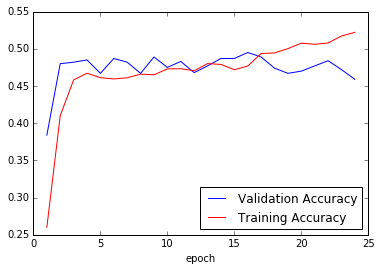

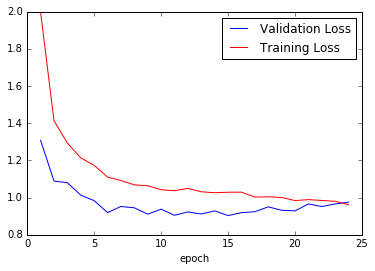

In [17]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

log = h5py.File('Training_logs_DMN_plus.h5','r+') # Loading logs about change of training and validation loss and accuracy over epochs

y1 = log['val_acc'][...]
y2 = log['acc'][...]

x = np.arange(1,len(y1)+1,1) # (1 = starting epoch, len(y1) = no. of epochs, 1 = step) 

plt.plot(x,y1,'b',label='Validation Accuracy') 
plt.plot(x,y2,'r',label='Training Accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.show()

y1 = log['val_loss'][...]
y2 = log['loss'][...]

plt.plot(x,y1,'b',label='Validation Loss')
plt.plot(x,y2,'r',label='Training Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.show()

In [18]:
with tf.Session() as sess: # Begin session
    
    print 'Loading pre-trained weights for the model...'
    saver = tf.train.Saver()
    saver.restore(sess, 'DMN_Model_Backup/model.ckpt')
    sess.run(tf.global_variables())
    print '\nRESTORATION COMPLETE\n'
    
    print 'Testing Model Performance...'
    
    total_test_loss = 0
    total_test_acc = 0
    
    test_batch_size = 100 #(should be able to divide total no. of test samples without remainder)
    batches_test_fact_stories,batches_test_questions,batches_test_answers = create_batches(test_fact_stories,test_questions,test_answers,test_batch_size)
        
    for i in xrange(len(batches_test_questions)):
        test_loss, test_acc = sess.run([cost, accuracy], 
                                        feed_dict={tf_facts: batches_test_fact_stories[i], 
                                                   tf_questions: batches_test_questions[i], 
                                                   tf_answers: batches_test_answers[i],
                                                   training: False})
        total_test_loss += test_loss
        total_test_acc += test_acc
                      
            
    avg_test_loss = total_test_loss/len(batches_test_questions) 
    avg_test_acc = total_test_acc/len(batches_test_questions) 


    print "\nTest Loss= " + \
          "{:.3f}".format(avg_test_loss) + ", Test Accuracy= " + \
          "{:.3f}%".format(avg_test_acc*100)+""


Loading pre-trained weights for the model...
INFO:tensorflow:Restoring parameters from DMN_Model_Backup/model.ckpt

RESTORATION COMPLETE

Testing Model Performance...

Test Loss= 0.914, Test Accuracy= 50.100%
